***Méthodes numériques: Module 4***

# Grey Scott model

Nous commencons par importer la librairie numpy, matplotlib et matplotlib.cm qui nous permettra de dessiner des **cartes**.
Ensuite nous définissons tous nos paramètres et nous importons le fichier contenant les données initiales u et v qui se trouve dans le fichier data du même dépôt.

In [1]:
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
%matplotlib inline

In [2]:
uvinitial = numpy.load('./data/uvinitial.npz')
U = uvinitial['U']
V = uvinitial['V']

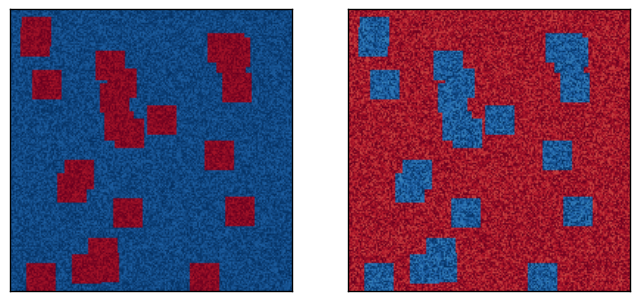

In [3]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(U, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(V, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

**Paramètres**

In [4]:
n = 192
I1=numpy.array([0.00016, 0.00008, 0.035, 0.065]) # Bacteria 1 
dh = 5/(n-1) #delta
T=8000

In [5]:
def dtandnt(CI):
    dt = .9 * dh**2 / (4*max(CI[0],CI[1]))
    nt=int(T/dt)
    return (dt,nt)

Le système d'équations différentielles à résoudre s'écrit:


\begin{align}
\frac{\partial u}{\partial t} &= D_u \nabla ^2 u - uv^2 + F(1-u)\\
\frac{\partial v}{\partial t} &= D_v \nabla ^2 v + uv^2 - (F + k)v
\end{align}

## Méthode explicite

Nous allons le discrétiser vers l'avant dans le temps et par un schéma centré dans l'espace (forward-time,centred-space). Nous allons le résoudre par un schéma explicite: la discrétisation dans l'espace s'effectue au temps n:


\begin{align}
\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}= D_{u}*(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n})\\
\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}=D_{v}*(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-(F+k)v_{i,j}^{n}
\end{align}

On pose ensuite 
\begin{align}
\Delta x^2=\Delta y^2=\delta^2\\
\Delta t= \frac{9}{40}\frac{\delta^2}{\max(D_u, D_v)}
\end{align}

On met tous les termes connus dans le membre de droite et les termes inconnus dans le membre de gauche:

\begin{align}
u_{i,j}^{n+1}=u_{i,j}^{n}+\Delta t\left(Du*(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\delta^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\delta^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n})\right)\\
v_{i,j}^{n+1}=v_{i,j}^{n}+\Delta t\left(Dv*(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\delta^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\delta^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-(F+k)v_{i,j}^{n}\right)
\end{align}
c'est-à-dire:
\begin{align}
u_{i,j}^{n+1}=u_{i,j}^{n}*(1-4\frac{\Delta t*Du}{\delta^2})+\Delta t\left(Du*(\frac{u_{i+1,j}^{n}+u_{i-1,j}^{n}+u_{i,j+1}^{n}+u_{i,j-1}^{n}}{\delta^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n})\right)\\
v_{i,j}^{n+1}=v_{i,j}^{n}*(1-4\frac{\Delta t*Dv}{\delta^2})+\Delta t\left(Dv*(\frac{v_{i+1,j}^{n}+v_{i-1,j}^{n}+v_{i,j+1}^{n}+v_{i,j-1}^{n}}{\delta^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-(F+k)v_{i,j}^{n}\right)
\end{align}

#### Résolution explicite:

In [6]:
def greyscott(u0,v0,CI):
    Du=CI[0]
    Dv=CI[1]
    F=CI[2]
    k=CI[3]
    [dt,nt]=dtandnt(CI)
    ucopy=u0.copy()
    vcopy=v0.copy()
    for j in range (nt):
        uk=ucopy.copy()
        vk=vcopy.copy()
        ucopy[1:-1,1:-1]=uk[1:-1,1:-1]*(1-4*dt*Du/dh**2)+dt*Du*(uk[2:,1:-1]+uk[:-2,1:-1]+uk[1:-1,2:]+uk[1:-1,:-2])/(dh**2)\
                        -dt*uk[1:-1,1:-1]*(vk[1:-1,1:-1])**2+dt*F*(1-uk[1:-1,1:-1])
        vcopy[1:-1,1:-1]=vk[1:-1,1:-1]*(1-4*dt*Dv/dh**2)+dt*Dv*(vk[2:,1:-1]+vk[:-2,1:-1]+vk[1:-1,2:]+vk[1:-1,:-2])/(dh**2)\
                        +dt*uk[1:-1,1:-1]*(vk[1:-1,1:-1])**2-dt*(F+k)*vk[1:-1,1:-1]
        #conditions de Neumann:
        ucopy[:,0]=ucopy[:,1]
        ucopy[0,:]=ucopy[1,:]
        ucopy[:,191]=ucopy[:,190]
        ucopy[191,:]=ucopy[190,:]
        vcopy[:,0]=vcopy[:,1]
        vcopy[0,:]=vcopy[1,:]
        vcopy[:,191]=vcopy[:,190]
        vcopy[191,:]=vcopy[190,:]
        
    return (ucopy,vcopy)

### Cartes

In [7]:
def solandmap(CI):
    sol=greyscott(U,V,CI)
    fig = pyplot.figure(figsize=(8,5))
    pyplot.subplot(121)
    pyplot.imshow(sol[0], cmap = cm.RdBu)
    pyplot.xticks([]), pyplot.yticks([]);
    pyplot.subplot(122)
    pyplot.imshow(sol[1], cmap = cm.RdBu)
    pyplot.xticks([]), pyplot.yticks([]);

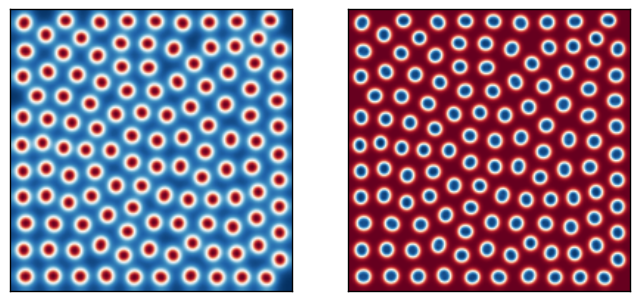

In [8]:
solandmap(I1)

### Solution des questions posées:
Pour vérifier que notre code donne la bonne solution, nous fournissons les valeurs de u de la 100 ligne toutes les 40 valeurs.
Nous utilisons la fonction numpy.round pour obtenir les valeurs à la quatrième décimale.

In [9]:
sol=greyscott(U,V,I1)
print(numpy.round(sol[0][100,::40],4))

[ 0.9247  0.8501  0.6682  0.902   0.904 ]


### Evolution dans le temps
Nous allons à présent animer notre solution pour rendre le processus plus visuel.
Comme il s'agit d'une carte, nous ne pouvons pas utiliser les mêmes codes que dans les modules différents. Nous nous sommes inspirés de la documentation matplotlib et de l'exemple de ce lien: http://matplotlib.org/examples/animation/dynamic_image2.html.

In [71]:
from matplotlib import animation
from IPython.display import HTML

Nous rappelons les paramètres utilisés:

In [72]:
#Paramètres fixes
n=192
dh = 5/(n-1)
T=8000

#Paramètres variables
I1=numpy.array([0.00016, 0.00008, 0.035, 0.065]) # Bacteria 1

Pour créer la vidéo, nous avons besoin de vecteurs reprenant nos solutions pour u et v à chaque étapes de temps j. Nous devons donc modifier un petit peu notre code pour cela.

In [73]:
def vectors(CI):
    [dt,nt]=dtandnt(CI)
    uu=numpy.zeros((nt,n,n))
    uu[0]=U
    vv=numpy.zeros((nt,n,n))
    vv[0]=V
    Du=CI[0]
    Dv=CI[1]
    F=CI[2]
    k=CI[3]
    
    for j in range (nt-1):
        uu[j+1,1:-1,1:-1]=uu[j,1:-1,1:-1]*(1-4*dt*Du/dh**2)+dt*Du*(uu[j,2:,1:-1]+uu[j,:-2,1:-1]+uu[j,1:-1,2:]+uu[j,1:-1,:-2])/(dh**2)\
                        -dt*uu[j,1:-1,1:-1]*(vv[j,1:-1,1:-1])**2+dt*F*(1-uu[j,1:-1,1:-1])
        vv[j+1,1:-1,1:-1]=vv[j,1:-1,1:-1]*(1-4*dt*Dv/dh**2)+dt*Dv*(vv[j,2:,1:-1]+vv[j,:-2,1:-1]+vv[j,1:-1,2:]+vv[j,1:-1,:-2])/(dh**2)\
                        +dt*uu[j,1:-1,1:-1]*(vv[j,1:-1,1:-1])**2-dt*(F+k)*vv[j,1:-1,1:-1]
        #conditions de Neumann:
        uu[j+1,:,0]=uu[j+1,:,1]
        uu[j+1,0,:]=uu[j+1,1,:]
        uu[j+1,:,191]=uu[j+1,:,190]
        uu[j+1,191,:]=uu[j+1,190,:]
        vv[j+1,:,0]=vv[j+1,:,1]
        vv[j+1,0,:]=vv[j+1,1,:]
        vv[j+1,:,191]=vv[j+1,:,190]
        vv[j+1,191,:]=vv[j+1,190,:]
    return(uu,vv)

Nous utilisons maintenant le même code que dans le lien, adapté à notre situation:

In [74]:
uu=vectors(I1)[0]
nt=len(uu)

In [75]:
fig = pyplot.figure(figsize=(8,5))
ims = []
for i in range(0,nt,100):#we do it each 100 step to lower the calculation time
    im = pyplot.imshow(uu[i], cmap=cm.RdBu, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
pyplot.close()

Et nous pouvons à présent lancer l'animation!

In [76]:
HTML(ani.to_html5_video())

Ceci correspond exactement à la solution montrée dans le module: ceci vérifie une fois de plus que notre code est correct.
Nous pouvons à présent utiliser ce code pour explorer d'autres paramètres!

### Autres paramètres:
Nous allons maintenant regarder d'autres patterns crées par différents paramètres initiaux. 

In [77]:
I2=numpy.array([0.00014, 0.00006, 0.035, 0.065]) # Bacteria 2
I3=numpy.array([0.00016, 0.00008, 0.060, 0.062]) # Coral
I4=numpy.array([0.00019, 0.00005, 0.060, 0.062]) # Fingerprint
I5=numpy.array([0.00010, 0.00010, 0.018, 0.050]) # Spirals
I6=numpy.array([0.00012, 0.00008, 0.020, 0.050]) # Spirals Dense
I7=numpy.array([0.00010, 0.00016, 0.020, 0.050]) # Spirals Fast
I8=numpy.array([0.00016, 0.00008, 0.020, 0.055]) # Unstable
I9=numpy.array([0.00016, 0.00008, 0.050, 0.065]) # Worms 1
I10=numpy.array([0.00016, 0.00008, 0.054, 0.063]) # Worms 2
I11=numpy.array([0.00016, 0.00008, 0.035, 0.060]) # Zebrafish

In [83]:
uu2= vectors(I4)[0]
nt=len(uu)

In [84]:
fig = pyplot.figure(figsize=(8,5))
ims = []
for i in range(0,nt,100):#we do it each 100 step to lower the calculation time
    im = pyplot.imshow(uu2[i], cmap=cm.RdBu, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
pyplot.close() 
    
HTML(ani.to_html5_video())

## Méthode implicite

Cette fois-ci nous utilisons la méthode implicite: la discrétisation dans l'espace s'effectue au temps n+1:
\begin{align}
\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}= D_{u}*(\frac{u_{i+1,j}^{n+1}-2u_{i,j}^{n+1}+u_{i-1,j}^{n+1}}{\Delta x^2}+\frac{u_{i,j+1}^{n+1}-2u_{i,j}^{n+1}+u_{i,j-1}^{n+1}}{\Delta y^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n})\\
\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}=D_{v}*(\frac{v_{i+1,j}^{n+1}-2v_{i,j}^{n+1}+v_{i-1,j}^{n+1}}{\Delta x^2}+\frac{v_{i,j+1}^{n+1}-2v_{i,j}^{n+1}+v_{i,j-1}^{n+1}}{\Delta y^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-(F+k)v_{i,j}^{n})
\end{align}

### [Compléter]


Posons les conditions de Neumann aux bords.

#### Bord inférieur : 
\begin{align}
\frac{u_{i,1}^{n+1}-u_{i,0}^{n+1}}{\delta}=0\\
\frac{v_{i,1}^{n+1}-v_{i,0}^{n+1}}{\delta}=0\\
\\
u_{i,1}^{n+1} = u_{i,0}^{n+1}\\
v_{i,1}^{n+1} = v_{i,0}^{n+1}
\end{align}

Alors, en j=1, on trouve une équation qui donne 
$u_{i,2}^{n+1}$ et une équation qui donne $v_{i,2}^{n+1}$.

### [Compléter]

In [ ]:
from scipy.linalg import solve

In [ ]:
n=32

In [ ]:
def constructMatrix(Du, dh, dt):
    
    A = numpy.zeros(((n-2)**2,(n-2)**2))
    
    row_number = 0 # row counter
    
    for j in range(1,n-1):
        for i in range(1,n-1):
            
              
            # Sides
            if i==1: # Left boundary
                A[row_number,row_number] = (1/dt)+3*Du/(dh**2) # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)       # fetch i+1
                A[row_number,row_number+n-2] = -Du/(dh**2)    # fetch j+1
                A[row_number,row_number-(n-2)] = -Du/(dh**2)  # fetch j-1
            
            elif i==n-2: # Right boundary
                A[row_number,row_number] = (1/dt)+3*Du/(dh**2) # Set diagonal
                A[row_number,row_number-1] = -Du/(dh**2)      # Fetch i-1
                A[row_number,row_number+n-2] = -Du/(dh**2)    # fetch j+1
                A[row_number,row_number-(n-2)] = -Du/(dh**2)  # fetch j-1
                
            elif j==1: # Bottom boundary
                A[row_number,row_number] = (1/dt)+3*Du/(dh**2) # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)       # fetch i+1
                A[row_number,row_number-1] = -Du/(dh**2)       # fetch i-1
                A[row_number,row_number+n-2] = -Du/(dh**2)    # fetch j+1
                
            elif j==n-2: # Top boundary
                A[row_number,row_number] = (1/dt)+3*Du/(dh**2) # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)      # fetch i+1
                A[row_number,row_number-1] = -Du/(dh**2)       # fetch i-1
                A[row_number,row_number-(n-2)] = -Du/(dh**2)  # fetch j-1
                
            # Interior points
            else:
                A[row_number,row_number] =  (1/dt)+4*Du/(dh**2) # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)     # fetch i+1
                A[row_number,row_number-1] = -Du/(dh**2)     # fetch i-1
                A[row_number,row_number+n-2] = -Du/(dh**2)   # fetch j+1
                A[row_number,row_number-(n-2)] = -Du/(dh**2) # fetch j-1
                
            row_number += 1 # Jump to next row of the matrix!
    
    return A           

In [ ]:
print(constructMatrix(I1[0], dh,dtandnt(I1,8000)[0]))